In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv, concat
sns.set_theme(context='notebook', style='white', font_scale=1.33)
%matplotlib inline

## Section 1: Posterior Predictive Checks

In [2]:
## Define parameters.
stan_model = 'infinite_m1_pp'
sessions = [1,2,3]

## Iteratively load models.
data = []

for i in sessions:
    
    ## Load posterior predictive check data.
    df = read_csv(os.path.join('stan_results', f'{stan_model}_s{i}_ppc.tsv.gz'), sep='\t', compression='gzip')
    
    ## Append.
    data.append(df)
    
## Concatenate DataFrames.
data = concat(data)

## Reformat columns.
data['robot'] = data['robot'].replace({0:'GW', 1:'NGW', 2:'GAL', 3:'NGAL'})

#### 1.1 Learning curves

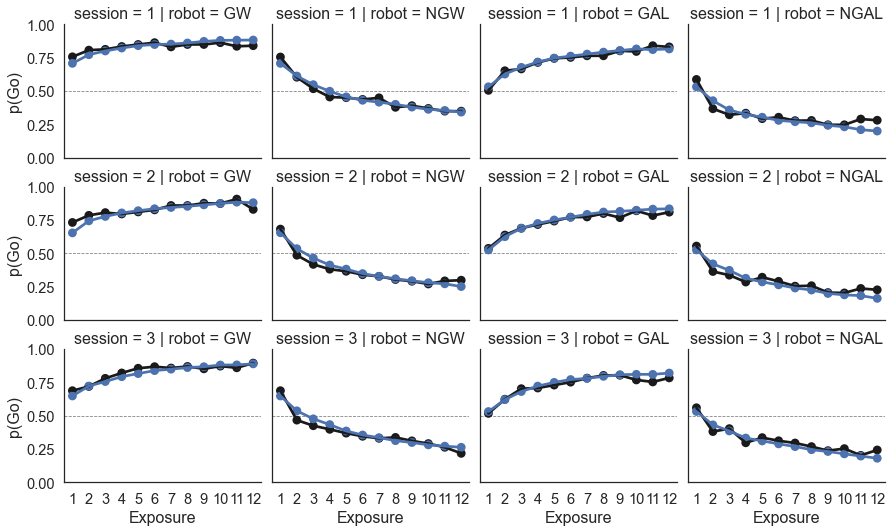

In [3]:
## Initialize canvas.
g = sns.FacetGrid(data, row='session', col='robot', col_order=['GW','NGW','GAL','NGAL'],
                  height=2.5, aspect=1.25)

## Plot action.
g.map(sns.pointplot, 'exposure', 'choice', order=np.arange(12)+1, ci=None, color='k')
g.map(sns.pointplot, 'exposure', 'Y_hat', order=np.arange(12)+1, ci=None)

## Add detail.
for ax in g.axes.flatten(): ax.axhline(0.5, lw=0.8, linestyle='--', color='0.5', zorder=-1)
g.set_xlabels('Exposure')
g.set_ylabels('p(Go)')
g.set(ylim=(0,1));

#### 1.2 Individual differences

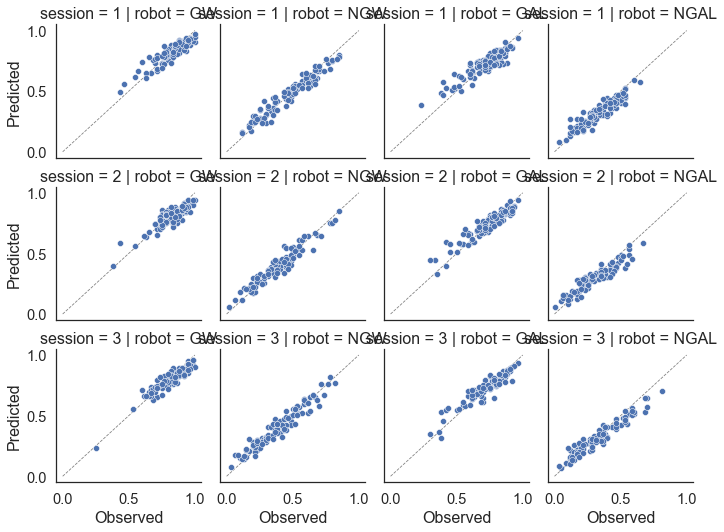

In [4]:
## Compute average action within participant.
agg = {'choice':'mean', 'Y_hat':'mean'}
gb = data.groupby(['session','subject','robot']).agg(agg).reset_index()

## Initialize canvas.
g = sns.FacetGrid(gb, row='session', col='robot', col_order=['GW','NGW','GAL','NGAL'],
                  height=2.5, aspect=1)

## Plot action.
g.map(sns.scatterplot, 'choice', 'Y_hat')

## Add details.
for ax in g.axes.flatten(): ax.plot([0,1], [0,1], lw=0.8, linestyle='--', color='0.5', zorder=-1)
g.set_xlabels('Observed')
g.set_ylabels('Predicted')
g.set(xlim=(-0.05,1.05), ylim=(-0.05,1.05));

#### 1.3 Individual differences (expanded)

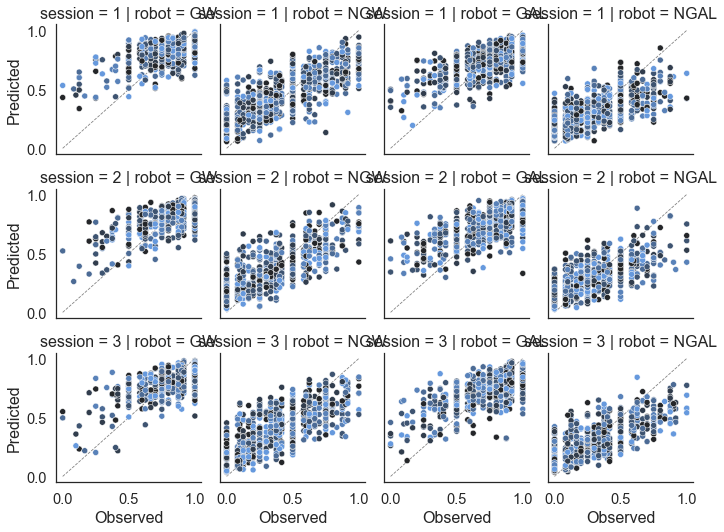

In [5]:
## Compute average action within participant.
agg = {'choice':'mean', 'Y_hat':'mean'}
gb = data.groupby(['session','subject','robot','rune']).agg(agg).reset_index()

## Update rune identity
f = lambda x: np.unique(x, return_inverse=True)[-1]
gb['rune'] = gb.groupby(['session','robot','subject']).rune.transform(f)

## Initialize canvas.
g = sns.FacetGrid(gb, row='session', col='robot', col_order=['GW','NGW','GAL','NGAL'],
                  height=2.5, aspect=1)
palette = sns.dark_palette("#69d", n_colors=6)

## Plot action.
g.map(sns.scatterplot, 'choice', 'Y_hat', 'rune', palette=palette)

## Add details.
for ax in g.axes.flatten(): ax.plot([0,1], [0,1], lw=0.8, linestyle='--', color='0.5', zorder=-1)
g.set_xlabels('Observed')
g.set_ylabels('Predicted')
g.set(xlim=(-0.05,1.05), ylim=(-0.05,1.05));

## Section 2: Model Parameters

In [6]:
## Define parameters.
stan_model = 'infinite_m1_pp'
sessions = [1,2,3]

## Iteratively load models.
data = []

for i in sessions:
    
    ## Load posterior predictive check data.
    df = read_csv(os.path.join('stan_results', f'{stan_model}_s{i}_summary.tsv'), sep='\t')
    
    ## Add metadata.
    df.insert(0, 'session', i)
    
    ## Append.
    data.append(df)
    
## Concatenate DataFrames.
data = concat(data).set_index('name')

#### 2.1 Parameter distributions

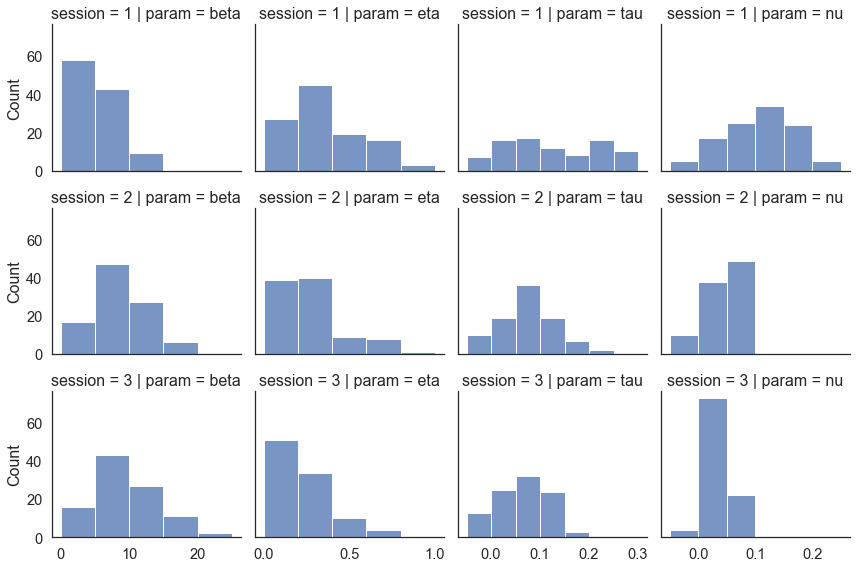

In [7]:
## Initialize canvas.
fig, axes = plt.subplots(3, 4, figsize=(12,8), sharey=True)

## Define details.
bins = [np.arange(0,30,5), np.linspace(0,1,6), np.arange(-0.05,0.35,0.05), np.arange(-0.05,0.30,0.05)]

## Main loop.
for i, session in enumerate(sessions):
    
    for j, param in enumerate(['beta','eta','tau','nu']):
        
        ## Extract parameter.
        x = data.query(f'session=={session}').T.filter(regex=f'^{param}\[').T.Mean.values
        
        ## Plot distribution.
        sns.histplot(x=x, bins=bins[j], ax=axes[i,j])
        
        ## Add detail.
        if not i == 2: axes[i,j].set_xticks([])
        axes[i,j].set_title(f'session = {session} | param = {param}')
        
sns.despine()
plt.tight_layout()